In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import streamlit as st

In [37]:
df=pd.read_csv(r'/workspaces/PYTHON_ML/projects/Datasets/qs_worldranking_cleaned.csv')

In [38]:
df.columns

Index(['RANK_2025', 'RANK_2024', 'Institution_Name', 'Location', 'Region',
       'SIZE', 'FOCUS', 'RES.', 'STATUS', 'Academic_Reputation_Score',
       'Academic_Reputation_Rank', 'Employer_Reputation_Score',
       'Employer_Reputation_Rank', 'Faculty_Student_Score',
       'Faculty_Student_Rank', 'Citations_per_Faculty_Score',
       'Citations_per_Faculty_Rank', 'International_Faculty_Score',
       'International_Faculty_Rank', 'International_Students_Score',
       'International_Students_Rank', 'International_Research_Network_Score',
       'International_Research_Network_Rank', 'Employment_Outcomes_Score',
       'Employment_Outcomes_Rank', 'Sustainability_Score',
       'Sustainability_Rank', 'Overall_Score'],
      dtype='object')

In [39]:
#Training Data Selection. For overall Score
df_train = df[df['Overall_Score'].notnull()]
df_train.shape

(593, 28)

In [40]:
# Selecting Features and Target
features = [
    'Academic_Reputation_Score', 'Employer_Reputation_Score', 'Faculty_Student_Score',
    'Citations_per_Faculty_Score', 'International_Faculty_Score', 'International_Students_Score',
    'International_Research_Network_Score', 'Employment_Outcomes_Score', 'Sustainability_Score',
    'Region', 'SIZE'
]

target = 'Overall_Score'



In [41]:
#Log-transform numerical scores 
#In my Language- Log transformation is used to reduce skewness,stable variance and make data more normally distributed
df_training = df_train.copy()
num_features = features[:-3]
for col in num_features:
    df_training[col] = np.log1p(df_training[col])

In [42]:
df_training.columns

Index(['RANK_2025', 'RANK_2024', 'Institution_Name', 'Location', 'Region',
       'SIZE', 'FOCUS', 'RES.', 'STATUS', 'Academic_Reputation_Score',
       'Academic_Reputation_Rank', 'Employer_Reputation_Score',
       'Employer_Reputation_Rank', 'Faculty_Student_Score',
       'Faculty_Student_Rank', 'Citations_per_Faculty_Score',
       'Citations_per_Faculty_Rank', 'International_Faculty_Score',
       'International_Faculty_Rank', 'International_Students_Score',
       'International_Students_Rank', 'International_Research_Network_Score',
       'International_Research_Network_Rank', 'Employment_Outcomes_Score',
       'Employment_Outcomes_Rank', 'Sustainability_Score',
       'Sustainability_Rank', 'Overall_Score'],
      dtype='object')

In [43]:
df_training.shape

(593, 28)

In [44]:
#making preprocessing pipeline for efficiency
pre_processor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('region', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Region']),
    ('size', OrdinalEncoder(categories=[['S', 'M', 'L', 'XL']]), ['SIZE'])
])

In [45]:
# making the - Model pipeline
pipeline = Pipeline([
    ('preprocessor', pre_processor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [46]:
# Split data
X = df_training[features]
y = df_training[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Region'], random_state=42)

In [49]:
# Train and evaluate with cross-validation
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R²: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

MSE: 18.27
R²: 0.95
Cross-Validation R²: -2.11 ± 0.92


<Figure size 1000x600 with 0 Axes>

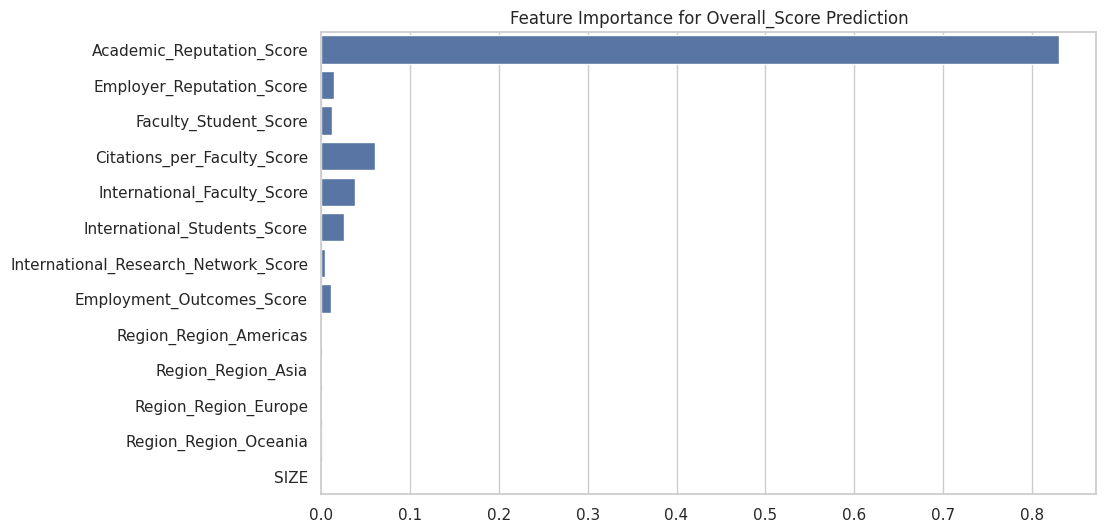

In [53]:
#Feature Importance
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
# Extracting feature importances from the model
feature_names = (num_features + 
                 [f"Region_{r}" for r in pipeline.named_steps['preprocessor'].named_transformers_['region'].get_feature_names_out(['Region'])] + 
                 ['SIZE'])
importances = pipeline.named_steps['model'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance for Overall_Score Prediction')
plt.show()